In [ ]:
"""
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

In [30]:
%load_ext autoreload
%autoreload 2
import cil
from cil.utilities.display import show2D
print(f'cil.__version__ = {cil.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cil.__version__ = 24.3.0


In [31]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from util.pcaReader import read_pca_file

filepath = '../CT_9V-battery_8W_1000ms/9V-battery.pca'
params = read_pca_file(filepath)
params

196 lines, found 143 values (discarded 124)


{'Version-pca': '2\n',
 'FDD': 648.629315,
 'FOD': 176.244875,
 'CalibValue': 0.0,
 'cx': 499.5,
 'cy': 499.5,
 'DetectorRot': 0.0,
 'Tilt': 0.0,
 'NumberImages': 1080,
 'StartImg': 1081,
 'RotationSector': 360.0,
 'NumberImagesCalib': 18,
 'DimX': 1000.0,
 'DimY': 1000.0,
 'FreeRay': 14540,
 'PixelsizeX': 0.2,
 'PixelsizeY': 0.2,
 'Voltage': 100.0,
 'Current': 80.0}

In [32]:
from util.getParameters import get_ct_parameters

SOD,\
SDD,\
ODD,\
pixel_size,\
num_pixels,\
num_projs,\
intensity = get_ct_parameters(params)

SOD: 176.245 mm
SDD: 648.629 mm
ODD: 472.384 mm
Detector pixel size: 0.200 mm
Projection image size: 1000 x 1000
1080 projection angles used
White level intensity: 14540


In [33]:
from util.setAcquisitionGeometry import set_ct_acquisition_geometry

ag = set_ct_acquisition_geometry(params=params)

SOD: 176.245 mm
SDD: 648.629 mm
ODD: 472.384 mm
Detector pixel size: 0.200 mm
Projection image size: 1000 x 1000
1080 projection angles used
White level intensity: 14540
3D Cone-beam tomography
System configuration:
	Source position: [   0.      , -176.244875,    0.      ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [  0.     , 472.38444,   0.     ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1000 1000]
	Pixel size: [0.2 0.2]
	Pixel origin: bottom-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 108
	Angles 0-9 in degrees: [ 0.       ,  3.3333333,  6.6666665, 10.       , 13.333333 , 16.666666 ,
 20.       , 23.333334 , 26.666666 , 30.       ]
	Angles 98-107 in degrees: [326.66666, 330.     , 333.33334, 336.66666, 340.     , 343.33334,
 346.66666, 350.     , 353.33334, 356.66666]
	Full angular array can be accessed wi

Number of dimensions: 3
Shape: (108, 1000, 1000)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



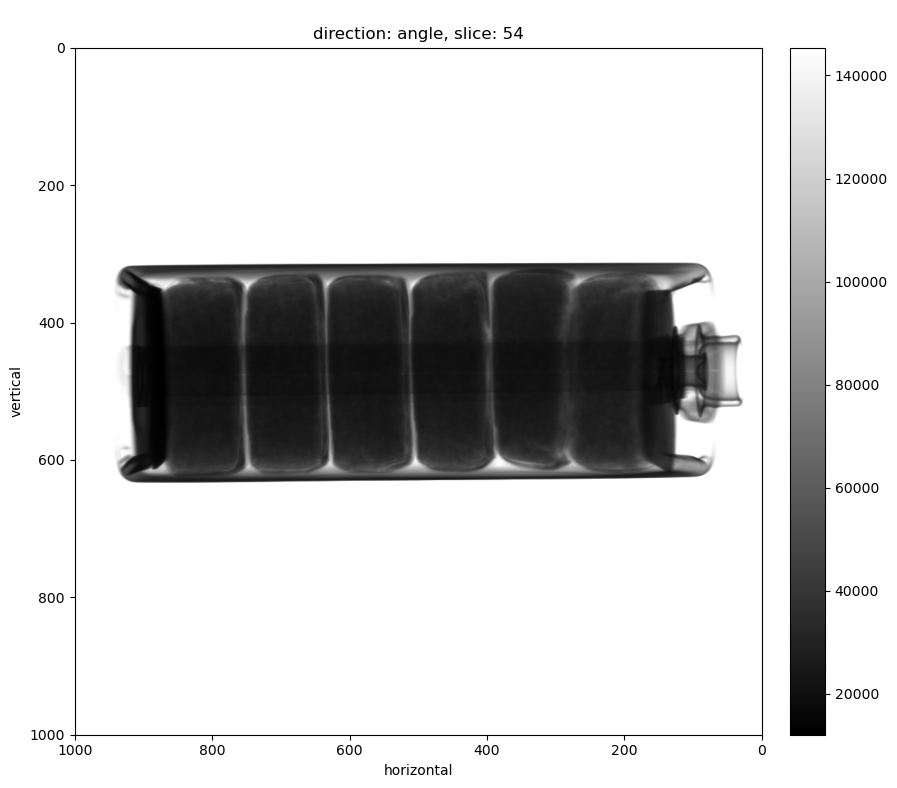

In [35]:
from util.readData import read_ct_data

# Transmission data
trans_data = read_ct_data(
    filename='../CT_9V-battery_8W_1000ms',
    acquisition_geometry=ag,
    num_projections=num_projs
    )

white_level = 14540, about 88.745 of the maximum (of 14 bit int)


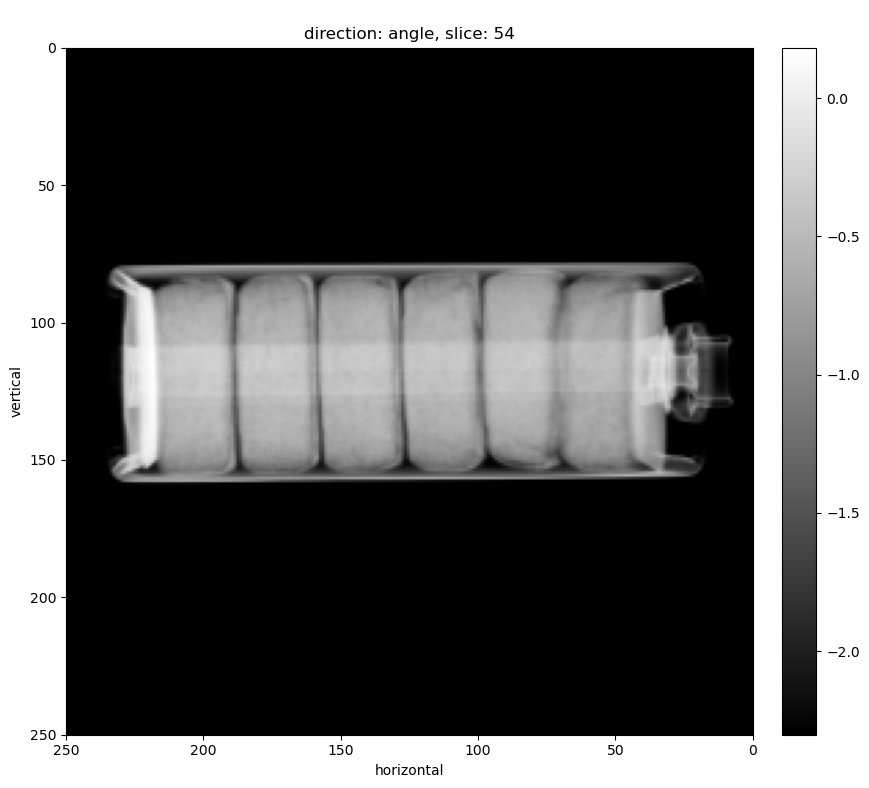

Number of dimensions: 3
Shape: (108, 250, 250)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



In [36]:
from util.convertData import convert_ct_data

# Absorption data
abs_data = convert_ct_data(trans_data, white_level=intensity)

In [37]:
del trans_data

In [38]:
# Setup for the image geometry
(_, nz, nx) = abs_data.shape

# Image geometry
ig = abs_data.geometry.get_ImageGeometry()
ig.voxel_num_x = nx
ig.voxel_num_y = nx
ig.voxel_num_z = nz
print(ig)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x250,y250,z250
voxel_size : x0.21737515825969106,y0.21737515825969106,z0.21737515825969106
center : x0,y0,z0



In [39]:
from cil.recon import FDK

# data.reorder('tigre')
abs_data.reorder('tigre')
fdk = FDK(abs_data, image_geometry=ig, filter='ram-lak')
fdk_recon = fdk.run()

FDK recon

Input Data:
	angle: 108
	vertical: 250
	horizontal: 250

Reconstruction Volume:
	vertical: 250
	horizontal_y: 250
	horizontal_x: 250

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 9
	Filter_inplace: False



In [ ]:
from cil.utilities.jupyter import islicer

islicer(fdk_recon, minmax=(0,0.1), direction=0, cmap='inferno')

(250, 250, 250)


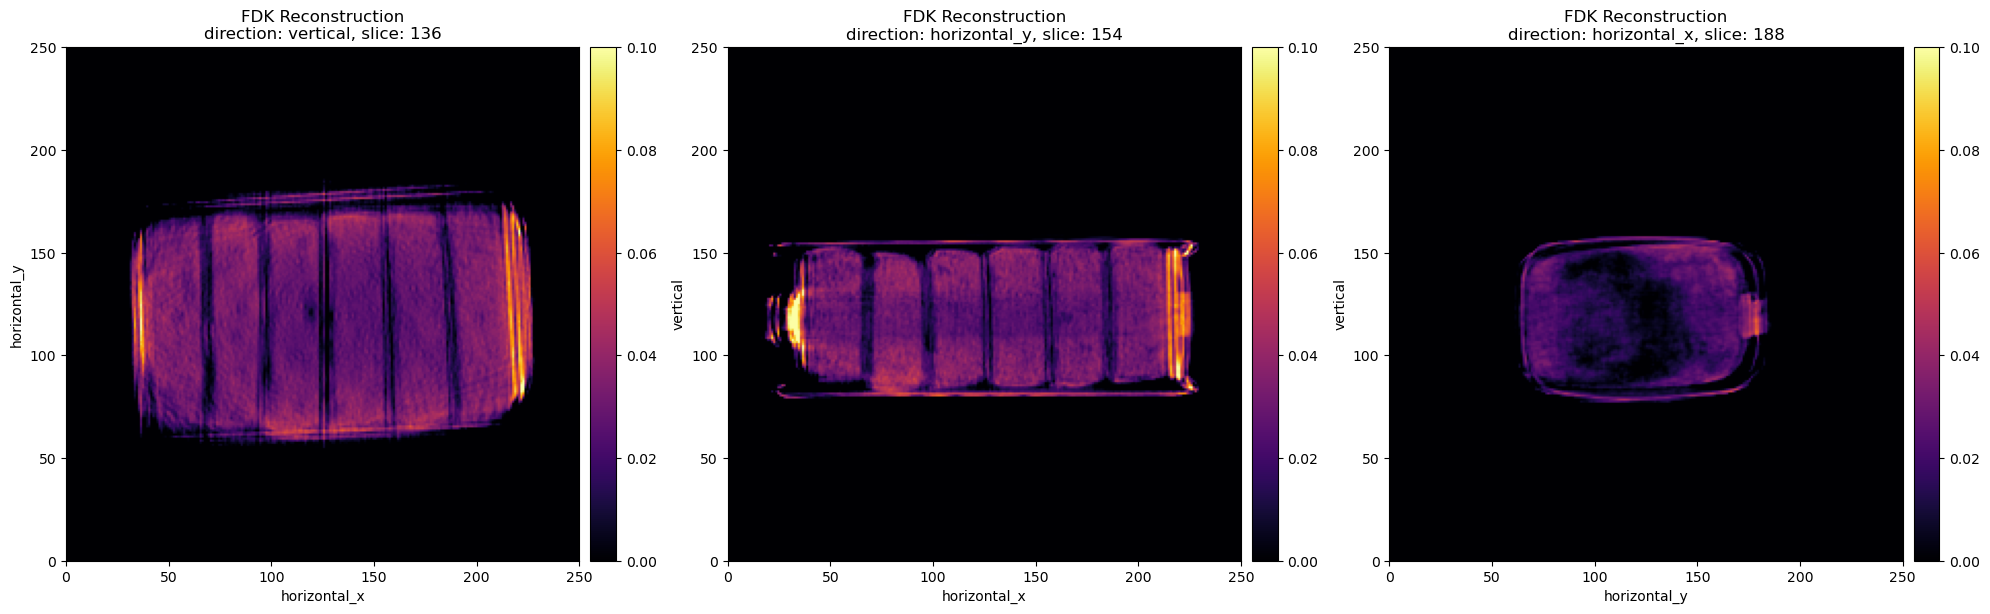

In [42]:
lb = 0 # lower bound
ub = .1 # upper bound
print(fdk_recon.shape)
show2D(fdk_recon, size=(20,10), fix_range=(lb,ub), cmap='inferno', title=f'FDK Reconstruction', num_cols=3, slice_list=[(0, 136), (1, 154), (2, 188)]);

Rebinning is complete.
Shape of the parallel-beam sinogram: (248, 55).
Shape of the parallel-beam sensor locations vector: (248,)
Shape of the parallel-beam angles: (55,).


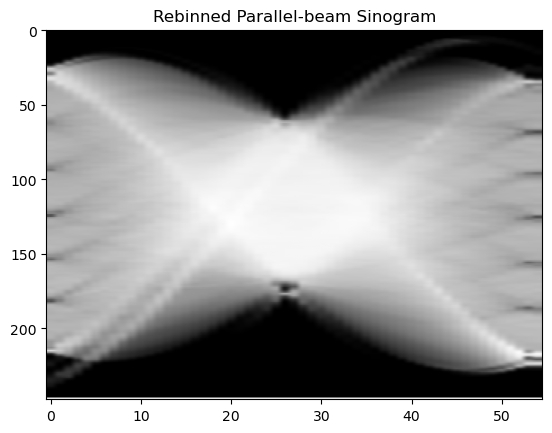

In [43]:
from util.fanToPara import convert_fan_to_parallel_geometry
index = 136
para_sinogram, para_loc, para_angles = convert_fan_to_parallel_geometry(data=abs_data, idx=index, source_origin_distance=SOD, direction=False)

Reconstruction complete.


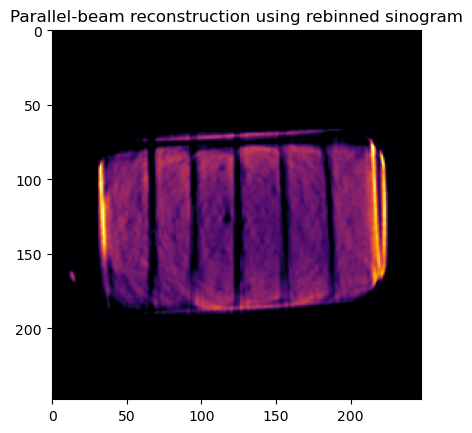

In [46]:
from util.fanToPara import reconstruct_parallel_sinogram

recon = reconstruct_parallel_sinogram(
    parallel_sinogram=para_sinogram,
    parallel_angles=para_angles,
    filter_name='hann',
    interpolation='linear',
    lower_bound=0,
    upper_bound=0.02,
    cmap='inferno')

In [ ]:
# import h5py

# output_file = f'9V_battery_sinogram_idx_{index}.h5'

# with h5py.File(output_file, 'w') as f:
#     f.create_dataset(f'9V_battery_sinogram_idx_{index}', data=para_sinogram.T)
#     f.create_dataset(f'9V_battery_angles_idx_{index}', data=para_angles)

# !mv '9V_battery_sinogram_idx_136.h5' '/home/santtalainen/KernelTomoRecons/simul/'

In [48]:
import numpy as np
np.save(f"9V_battery_sinogram_{index}.npy", para_sinogram)
np.save(f"9V_battery_para_loc_{index}.npy", para_loc)
np.save(f"9V_battery_para_angles_{index}.npy", para_angles)
!mv 9V_battery_sinogram_{index}.npy 9V_battery_para_loc_{index}.npy 9V_battery_para_angles_{index}.npy /home/santtalainen/Reconstructions/KernelCT/Data/